# 1. 先用預訓練好的神經網路提取影片特徵

In [39]:
import cv2
import os
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

In [42]:
import tensorflow as tf
# 设置 TensorFlow 使用 GPU
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

: 

In [27]:
# VGG16 model，只做到特徵提取
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

In [33]:
# Load dataset
dataset_dir = './dataset'

dataset = []
for category in os.listdir(dataset_dir):
    shape = (1, len(os.listdir(os.path.join(dataset_dir, category))))
    print(shape)
    shuffle = np.ones(shape)
    shuffle[0, np.random.choice(shape[1], size=shape[1]//2, replace=False)] = 0

    video_count = 0 # 計算這個類別有幾個影片
    category_path = os.path.join(dataset_dir, category)
    for index, video in enumerate(os.listdir(category_path)):
        video_path = os.path.join(category_path, video)
        if not os.path.isdir(video_path):
            continue
        if shuffle[0, index] == 0:
            continue

        frames = []
        cnt = -1
        for frame in os.listdir(video_path):
            cnt += 1
            if cnt % 3 != 0:
                continue
            frame_path = os.path.join(video_path, frame)
            img = cv2.imread(frame_path)
            img = np.expand_dims(img, axis=0)  # 拓展維度
            img = preprocess_input(img)  # 預處理
            frames.append(img)

        dataset.append(frames)


(1, 2028)
(1, 1976)
(1, 1716)
(1, 1560)
(1, 2288)
(1, 2392)


In [34]:
# 提取特徵
print(len(dataset))
dataset = np.array(dataset)
print(dataset.shape)

videos_features = []
for data in dataset:
    features = []
    for frame in data:
        print(frame.shape)
        feature = model.predict(frame)
        features.append(feature)
    videos_features.append(np.concatenate(features, axis=0))
    print(len(videos_features))


5876
(5876, 10, 1, 90, 160, 3)
(1, 90, 160, 3)
1/1 [==============================] - 1s 1s/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 156ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 62ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 87ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 53ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 51ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 60ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 49ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 124ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 52ms/step
1
(1, 90, 160, 3)
1/1 [==============================] - 0s 76ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 77ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 52ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 70ms/step
(1, 90, 160, 3)

KeyboardInterrupt: 

# 1. 用OpenCV提取影片的光流

In [23]:
import cv2
import os
import numpy as np

In [24]:
def extract_optical_flow(frames):
    features = []

    prev_frame = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    for frame in frames[1:]:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prev_frame, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        flow_feature = flow.reshape(-1)
        features.append(flow_feature)

        prev_frame = gray
    
    return np.array(features)

In [25]:
# 提取影片光流
dataset_dir = './dataset'

videos_features = [] # 存所有data特徵向量的特徵陣列
class_num = [] # 存每個類別的影片數量

for category in os.listdir(dataset_dir):
    video_count = 0 # 計算這個類別有幾個影片
    category_path = os.path.join(dataset_dir, category)
    for video in os.listdir(category_path):
        video_path = os.path.join(category_path, video)
        if not os.path.isdir(video_path):
            continue
        video_count += 1

        frames = []
        for frame in os.listdir(video_path):
            frame = cv2.imread(os.path.join(video_path, frame))
            frame = cv2.resize(frame, (160, 90))  # resize
            frames.append(frame)
            
        features = extract_optical_flow(frames)
        videos_features.append(features)
    class_num.append(video_count)

# 2. 再用DBSCAN分群

In [26]:
videos_features = np.array(videos_features)
print(videos_features.shape)

(106, 29, 28800)


In [71]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [74]:
data = np.array(videos_features)
X = data.reshape((data.shape[0], -1))
print(X.shape)

# PCA降維
pca = PCA(n_components=2)
X = pca.fit_transform(X)
print(X.shape)

(106, 835200)
(106, 2)


[-1  0 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1
  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  2 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  2
  2  2  2  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1  0
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


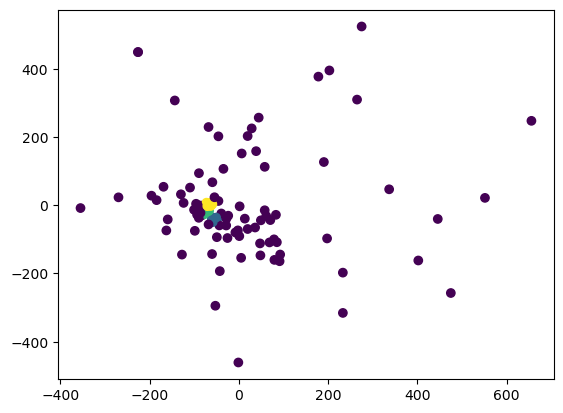

In [87]:
# 調整DBSCAN參數
eps = 10  # 範圍
min_samples = 5  # 成為核心的最小點數

# 應用DBSCAN算法
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)
print(dbscan.labels_)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
# labels 中的每个值表示对应数据点的簇标签，-1 表示噪声点

In [ ]:
# 分析分群結果
